# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp

import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData

import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5




In [2]:
import rmm
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")



CPU times: user 2.03 s, sys: 150 ms, total: 2.18 s
Wall time: 2.18 s


In [5]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 1.5 s, sys: 882 ms, total: 2.38 s
Wall time: 2.38 s


In [6]:
cudata.nnz

114212920

In [7]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 4.575448513031006


## Preprocessing

In [8]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [9]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 4.8 ms, sys: 0 ns, total: 4.8 ms
Wall time: 4.71 ms


In [10]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 4.44 ms, sys: 0 ns, total: 4.44 ms
Wall time: 4.36 ms


In [11]:
%%time
rsc.pp.calculate_qc(cudata,qc_vars=["MT","RIBO"])

CPU times: user 625 ms, sys: 288 ms, total: 913 ms
Wall time: 913 ms


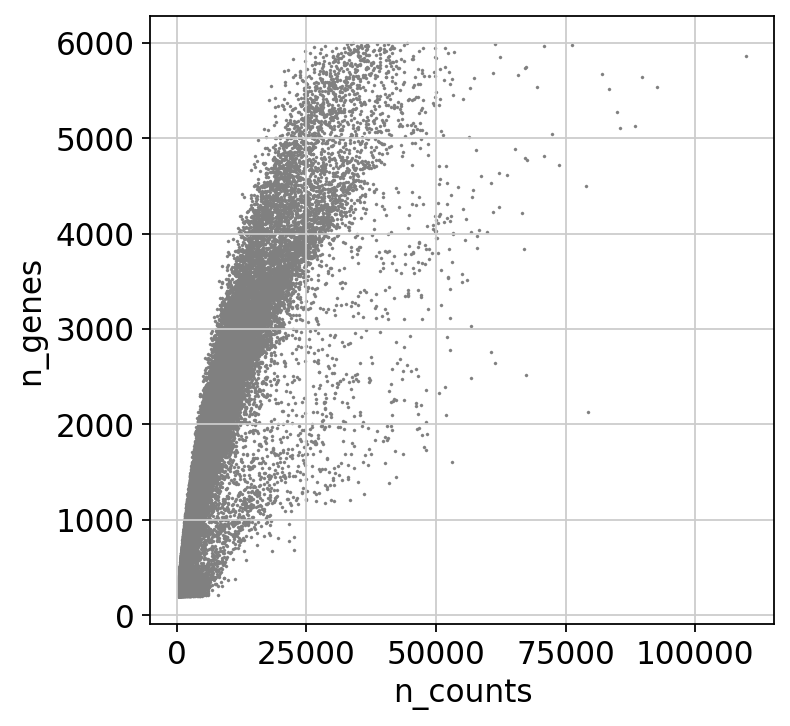

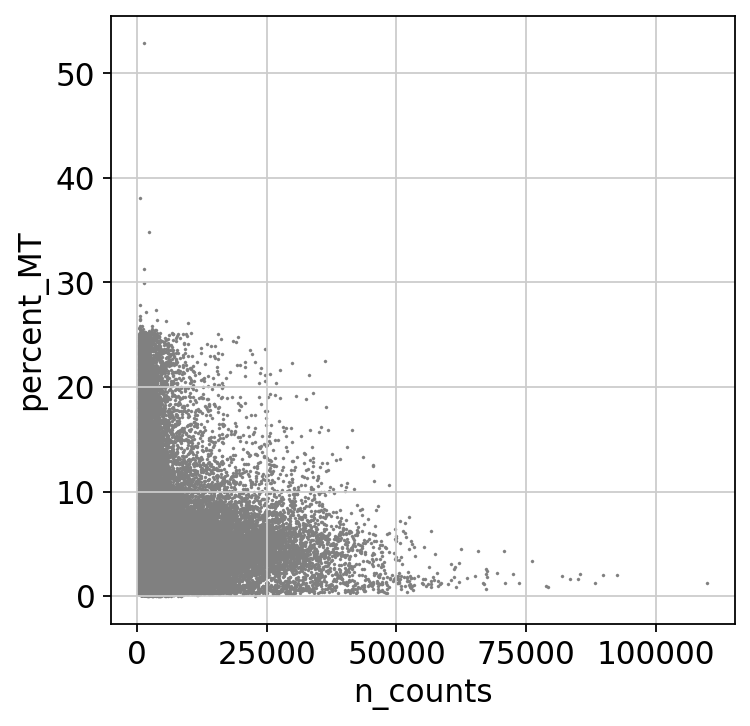

In [12]:
rsc.pl.scatter(cudata,"n_counts","n_genes")
rsc.pl.scatter(cudata,"n_counts","percent_MT")

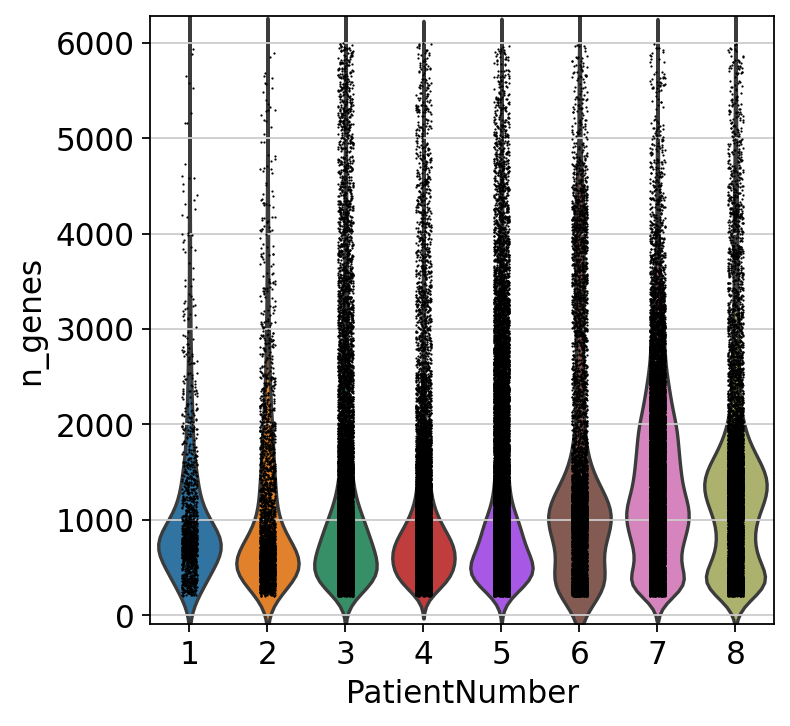

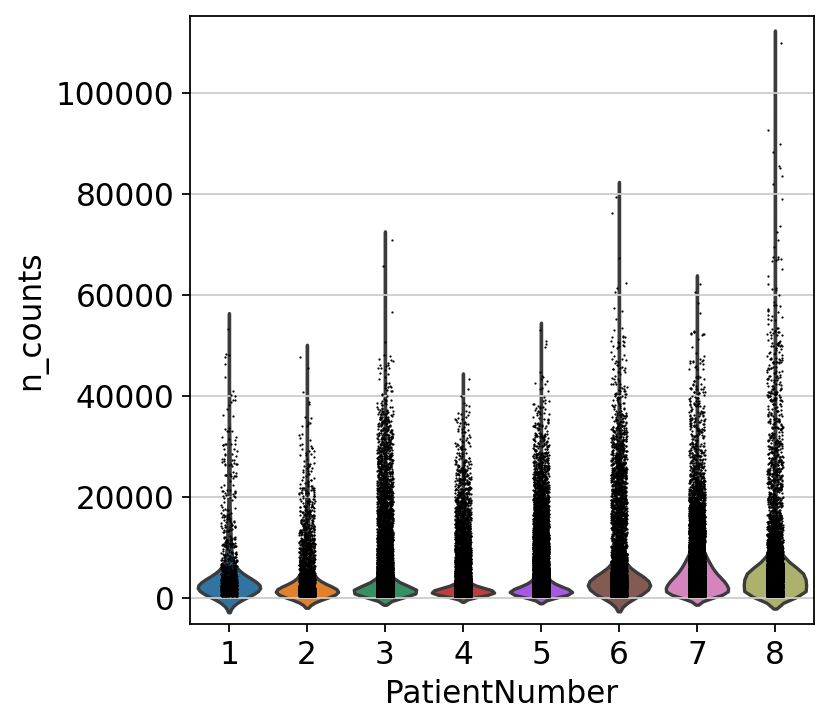

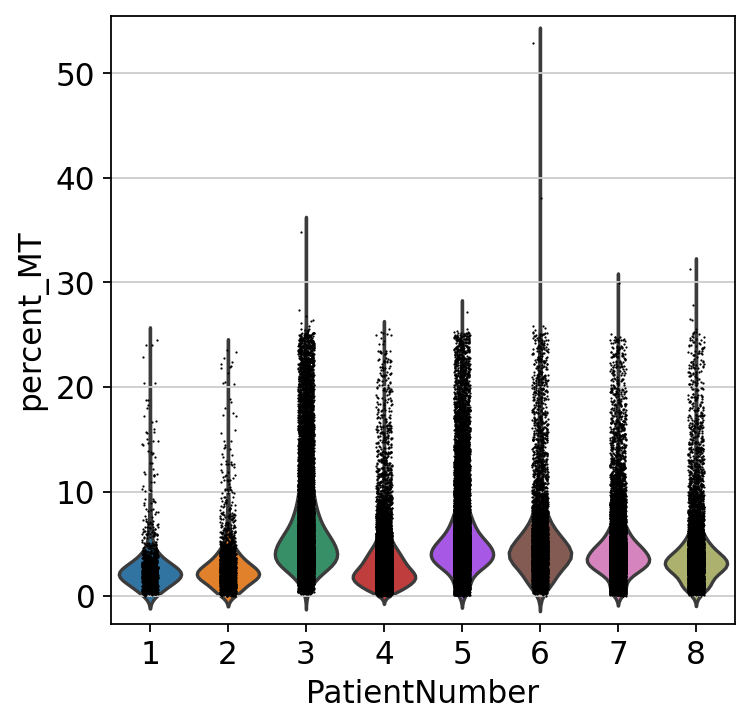

In [13]:
rsc.pl.violin(cudata,key="n_genes",groupby="PatientNumber")
rsc.pl.violin(cudata,key="n_counts",groupby="PatientNumber")
rsc.pl.violin(cudata,key="percent_MT",groupby="PatientNumber")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

The size of our count matrix is now reduced.

In [14]:
%%time
cudata = cudata[cudata.obs["n_genes"] < 5000]
cudata = cudata[cudata.obs["percent_MT"] < 20]

CPU times: user 121 ms, sys: 73.2 ms, total: 194 ms
Wall time: 194 ms


We also filter out genes that are expressed in less than 3 cells.

In [15]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 8034 genes based on n_cells
CPU times: user 240 ms, sys: 146 ms, total: 386 ms
Wall time: 386 ms


In [16]:
cudata.shape

(91068, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 249 µs, sys: 257 µs, total: 506 µs
Wall time: 381 µs


Next, we data transform the count matrix.

In [18]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 53.4 ms, sys: 23.5 ms, total: 77 ms
Wall time: 76.8 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `cell_ranger` for selecting highly variable genes based on the log normalized counts in `.X`

In [19]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 123 ms, sys: 49.1 ms, total: 172 ms
Wall time: 172 ms


In [20]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="cell_ranger")

CPU times: user 380 ms, sys: 85.9 ms, total: 466 ms
Wall time: 472 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

Now we restrict our cunndata object to the highly variable genes.

In [21]:
%%time
rsc.pp.filter_highly_variable(cudata)

CPU times: user 123 ms, sys: 82.8 ms, total: 206 ms
Wall time: 205 ms


Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [22]:
%%time
rsc.pp.regress_out(cudata,keys=["n_counts", "percent_MT"])

CPU times: user 1.97 s, sys: 769 ms, total: 2.74 s
Wall time: 2.73 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [23]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 229 ms, sys: 96.7 ms, total: 326 ms
Wall time: 325 ms


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [24]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 233 ms, sys: 160 ms, total: 393 ms
Wall time: 392 ms


In [25]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 7.44840931892395


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [26]:
%%time
rsc.tl.pca(adata, n_comps = 100)

CPU times: user 1.42 s, sys: 621 ms, total: 2.04 s
Wall time: 2.03 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

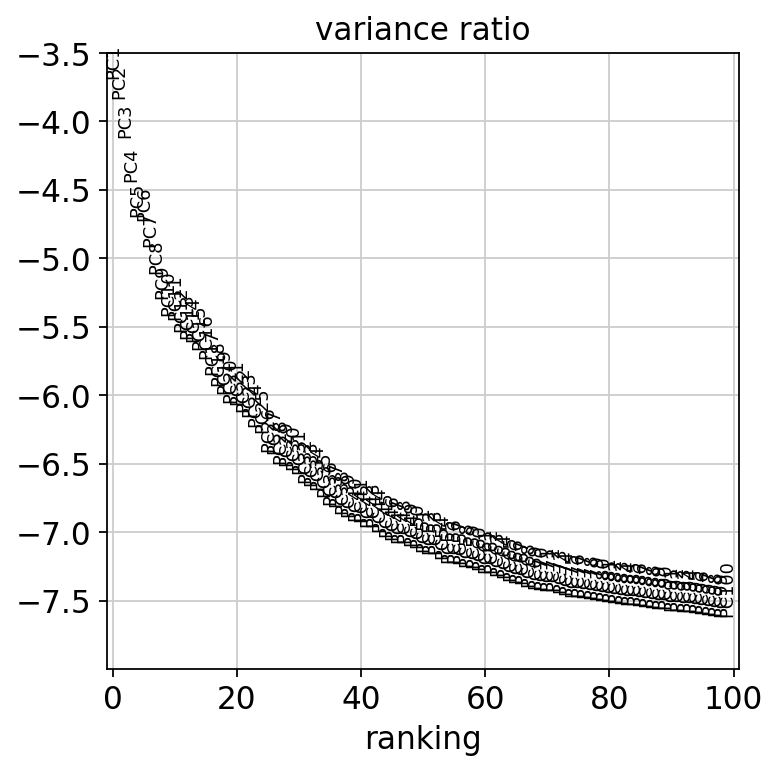

In [27]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [28]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 4.63 s, sys: 53.2 ms, total: 4.68 s
Wall time: 4.66 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [29]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 405 ms, sys: 16 ms, total: 421 ms
Wall time: 420 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering. As of the time of writing this notebook there is a known small bug in scanpy. The resoltion parameter of Louvain is not correctly passed to the cugraph funciton. This results in the resoltion beeing looked at 1.0.
Since the bug is fixed you can use `scanpy_gpu_funcs` implementation of Louvain.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [30]:
%%time
rsc.tl.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 657 ms, sys: 291 ms, total: 948 ms
Wall time: 946 ms


In [31]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 117 ms, sys: 9.32 ms, total: 126 ms
Wall time: 125 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


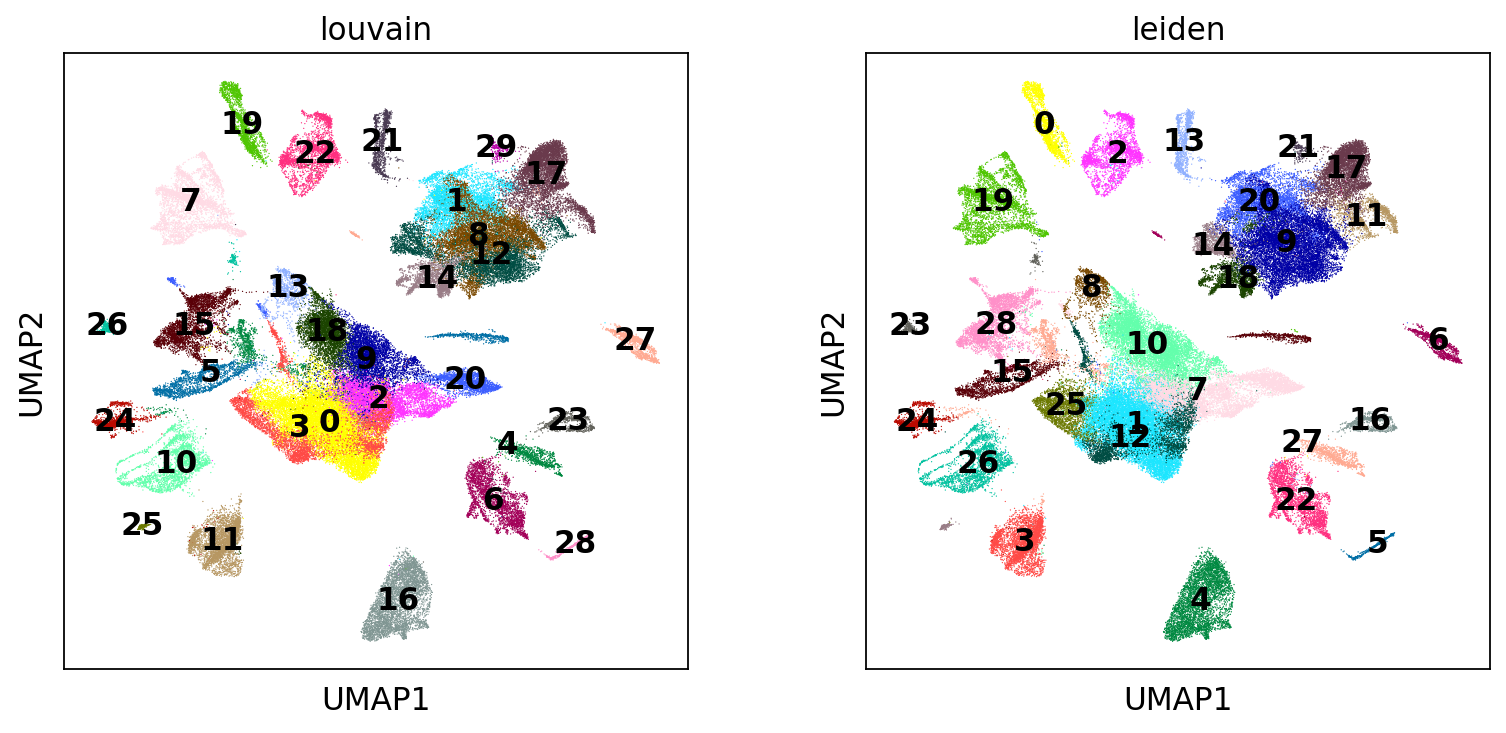

CPU times: user 596 ms, sys: 131 ms, total: 728 ms
Wall time: 569 ms


In [32]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


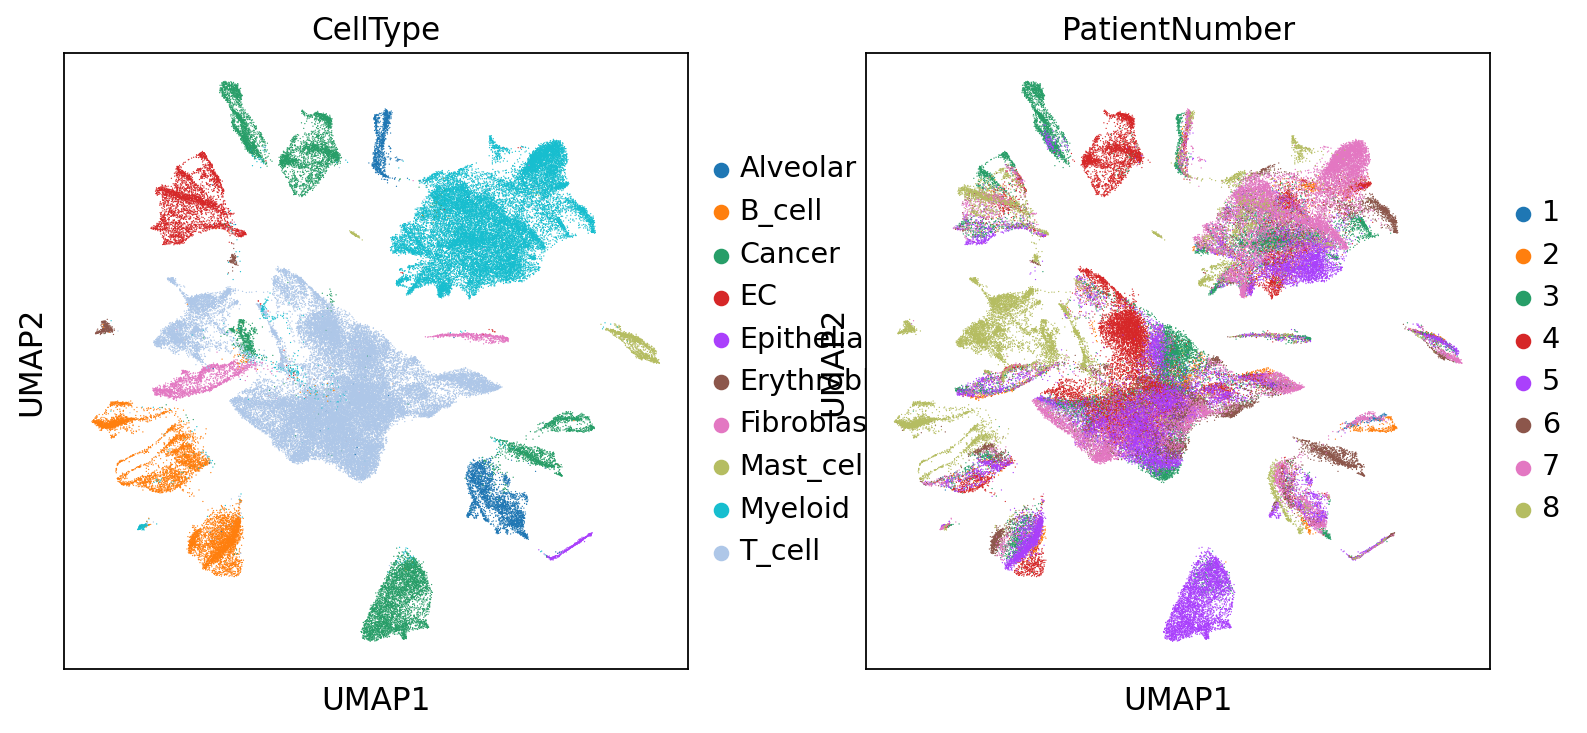

In [33]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [34]:
%%time
rsc.tl.tsne(adata, n_pcs = 40,perplexity=30,early_exaggeration=12, learning_rate=200)

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:08:31.267676] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.42 s, sys: 18.6 ms, total: 1.43 s
Wall time: 1.43 s


In [35]:
rsc.tl.kmeans(adata, n_clusters=8)

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


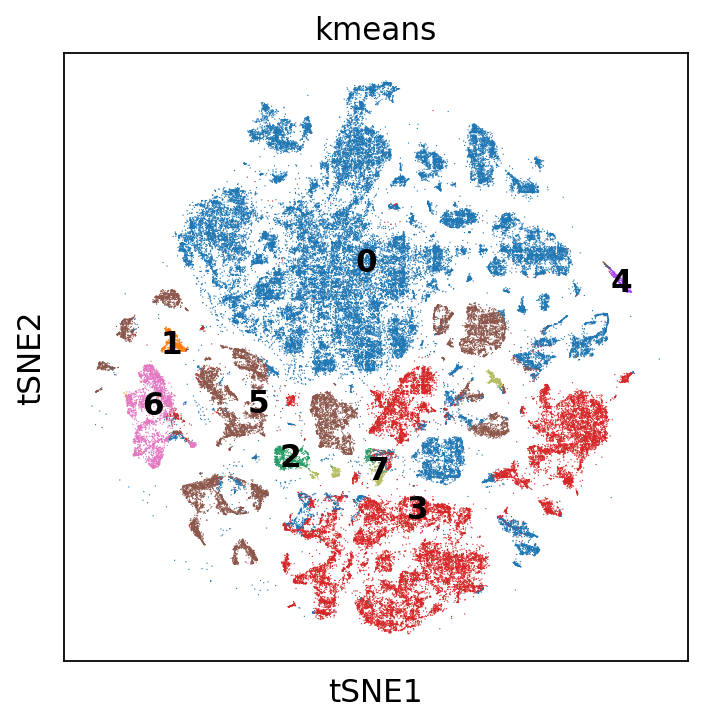

CPU times: user 335 ms, sys: 115 ms, total: 450 ms
Wall time: 293 ms


In [36]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


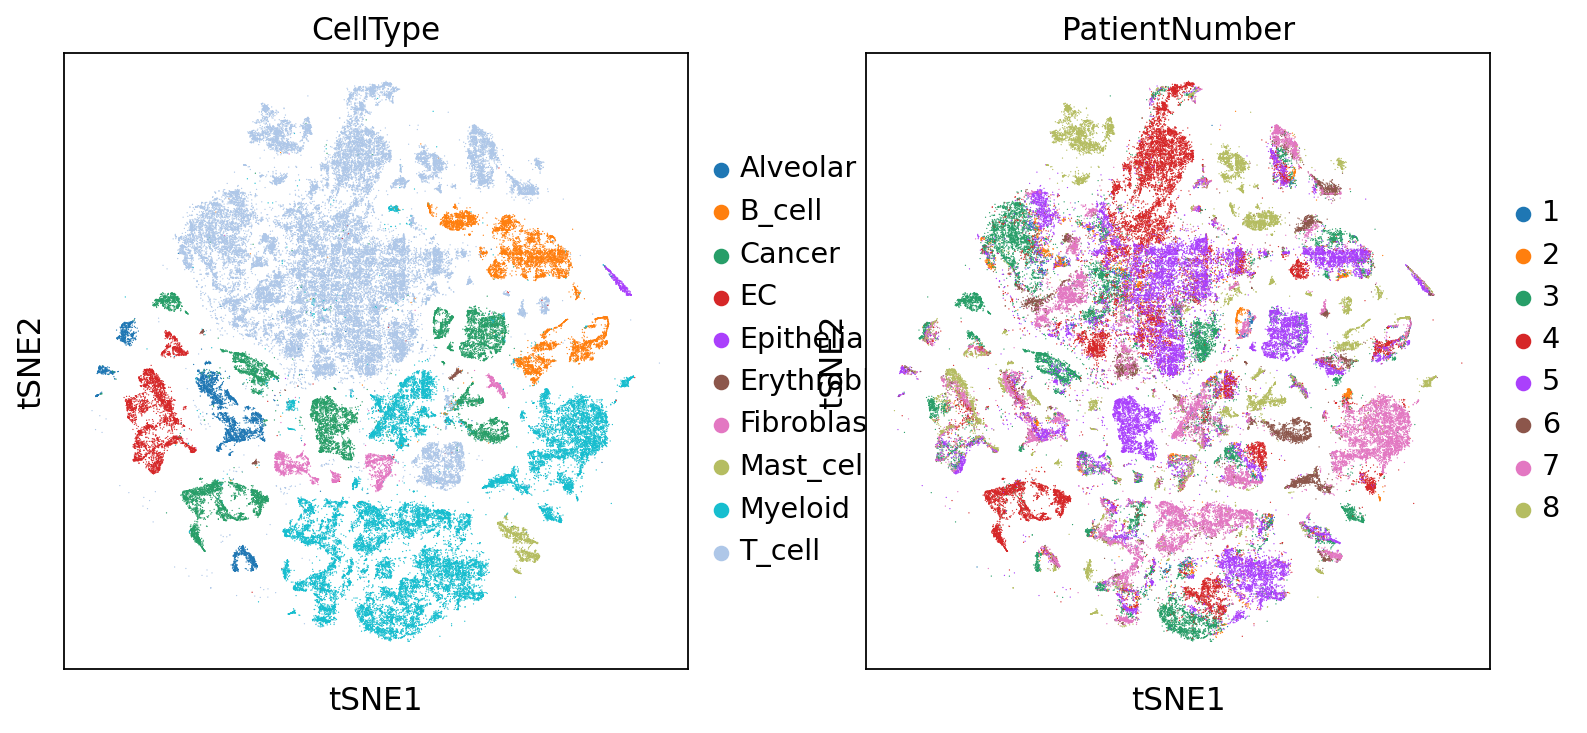

In [37]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [38]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.52 s, sys: 575 ms, total: 3.1 s
Wall time: 3.1 s


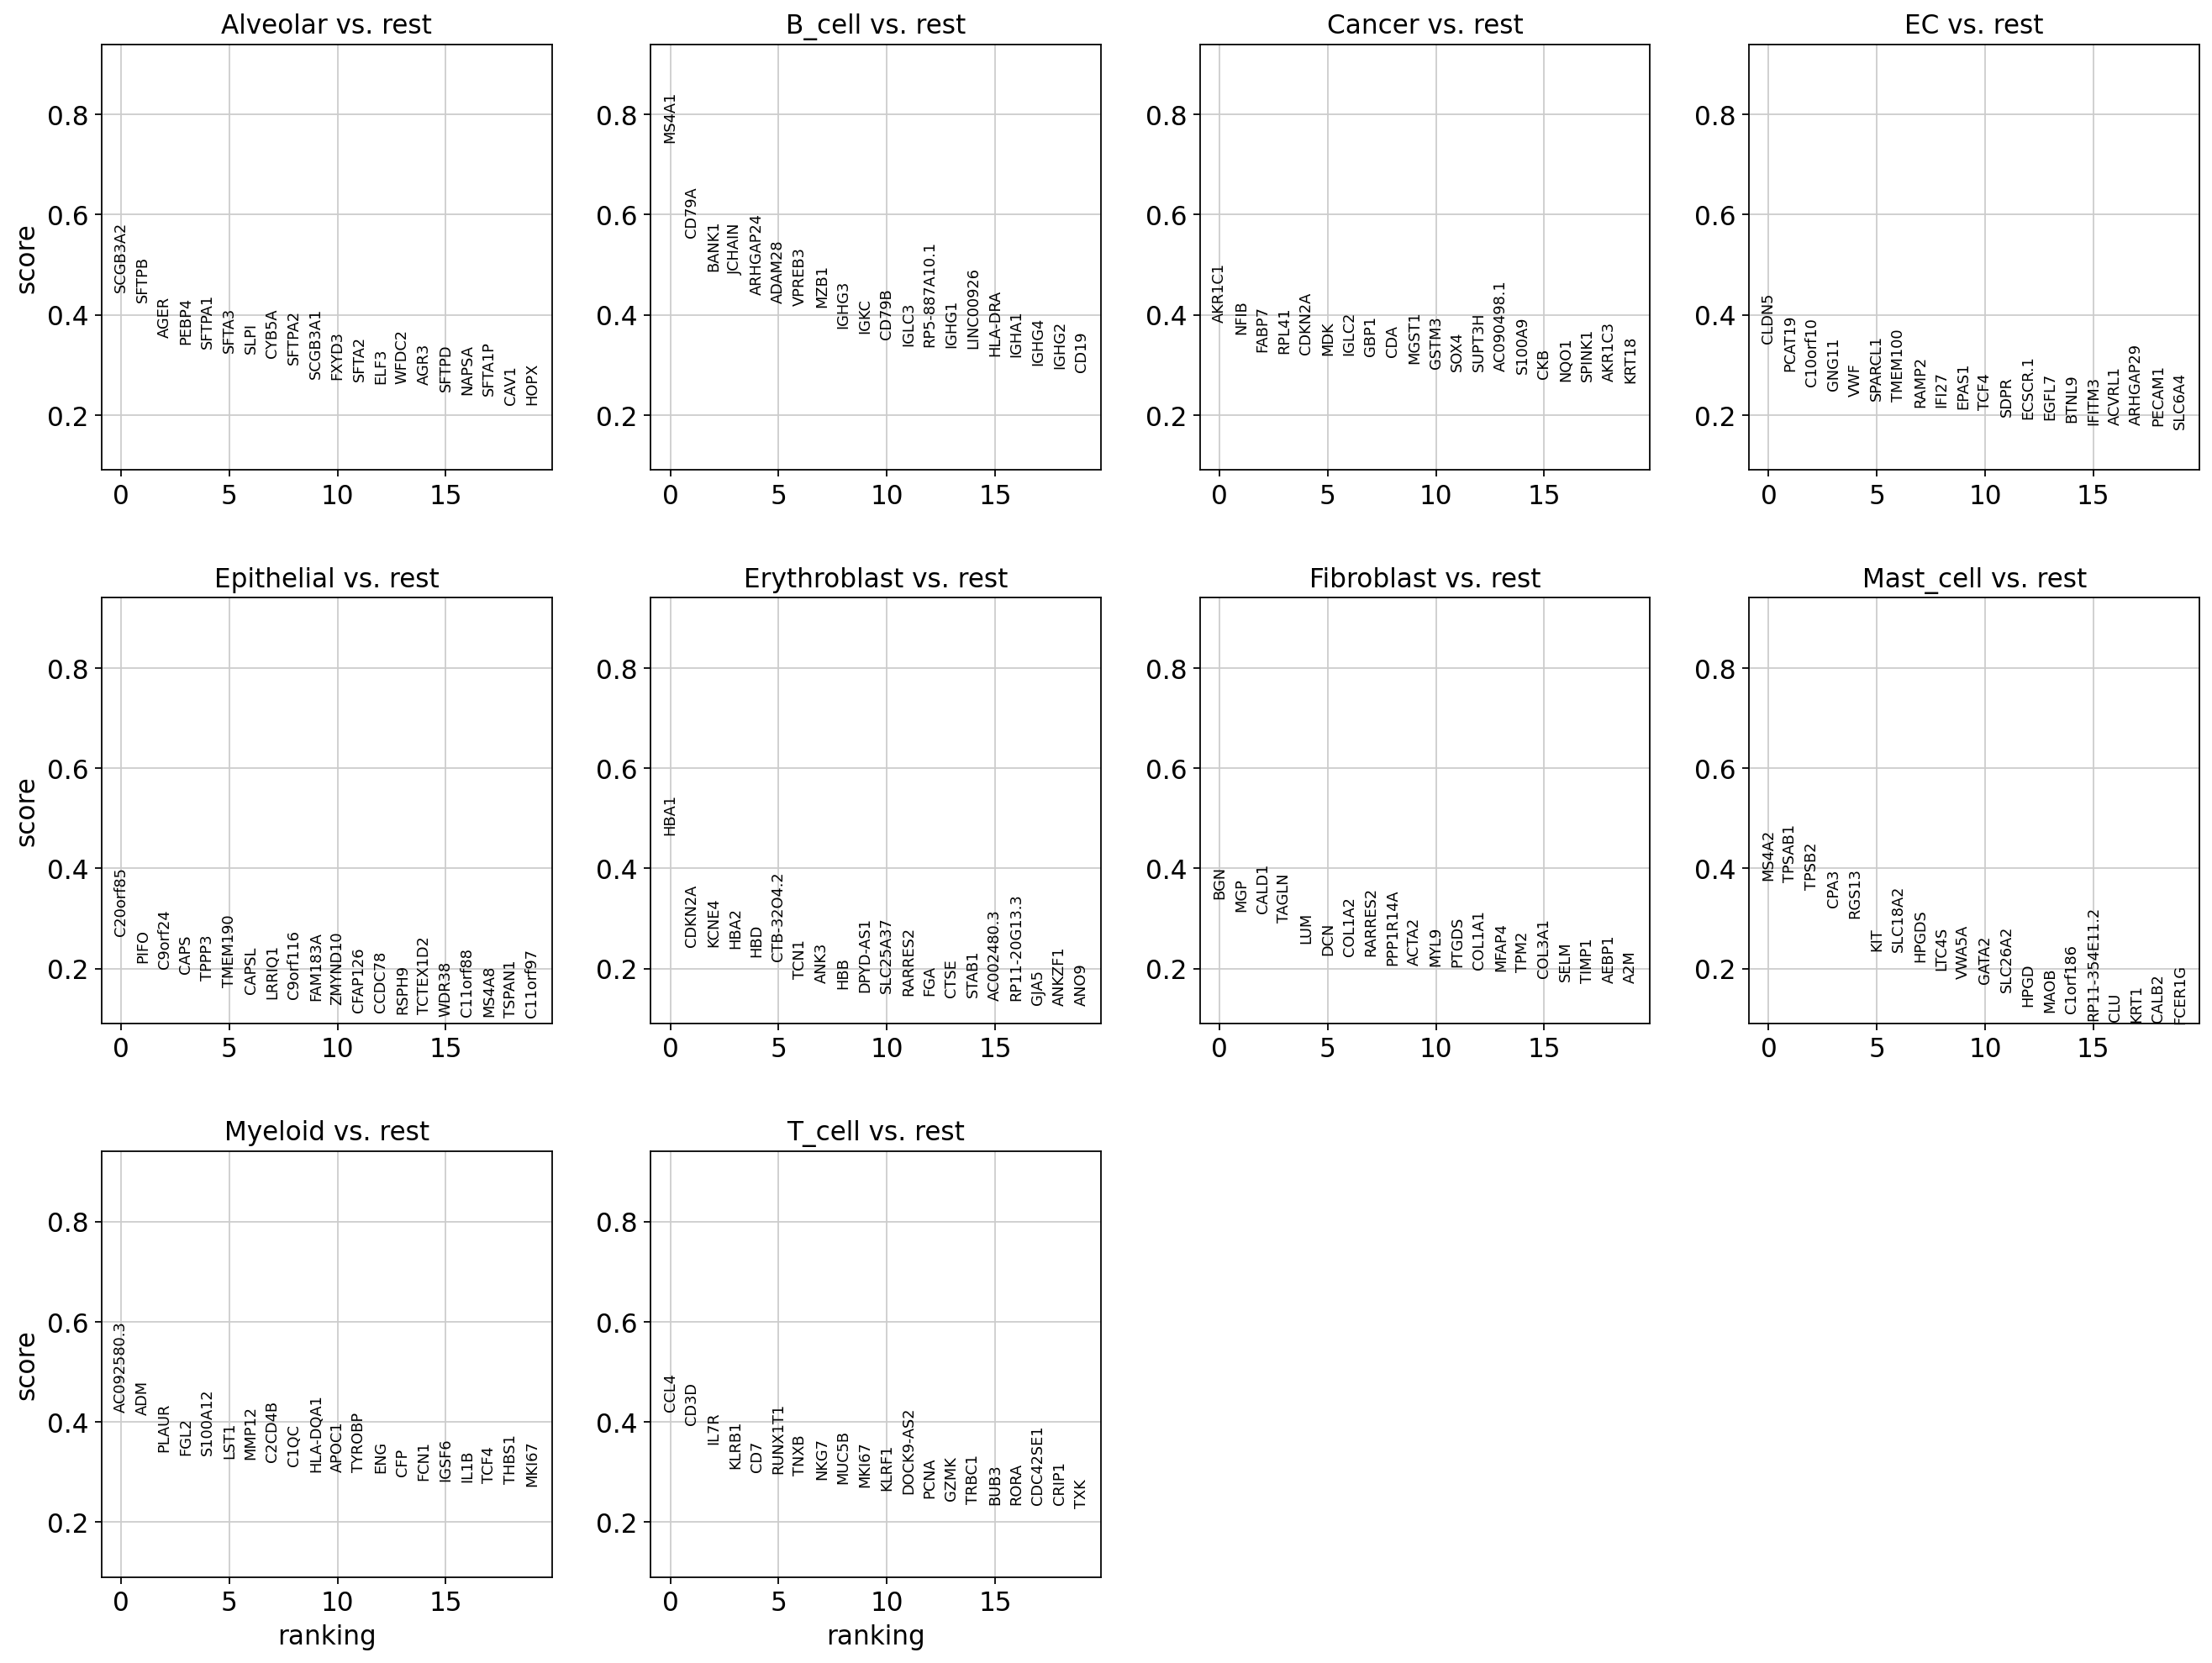

In [39]:
sc.pl.rank_genes_groups(adata)

In [40]:
post_time = time.time()

In [41]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 16.099522590637207


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [42]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

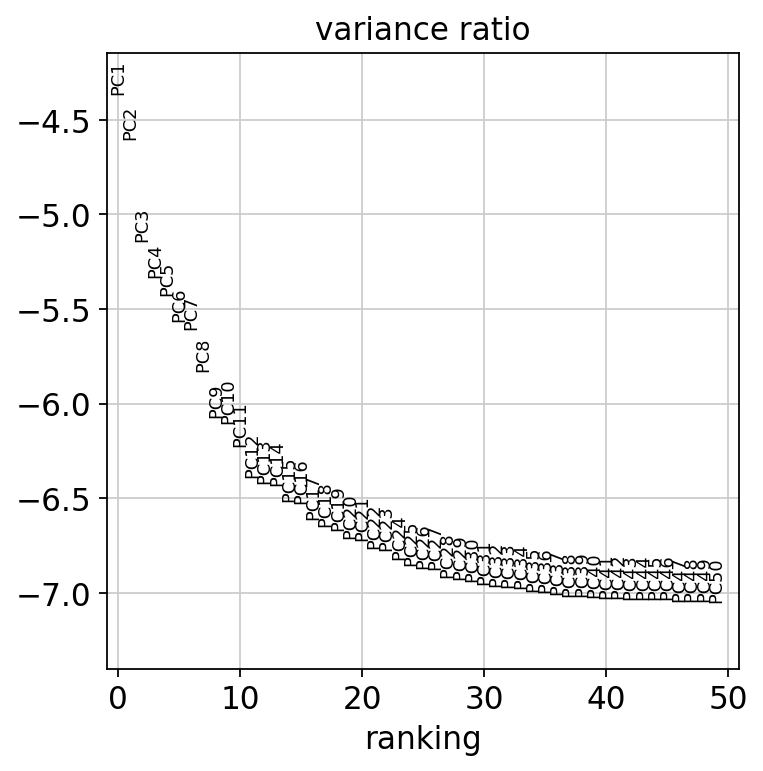

CPU times: user 930 ms, sys: 426 ms, total: 1.36 s
Wall time: 1.2 s


In [43]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [44]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsc.tl.louvain(tdata)

CPU times: user 1.16 s, sys: 75.3 ms, total: 1.24 s
Wall time: 1.22 s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


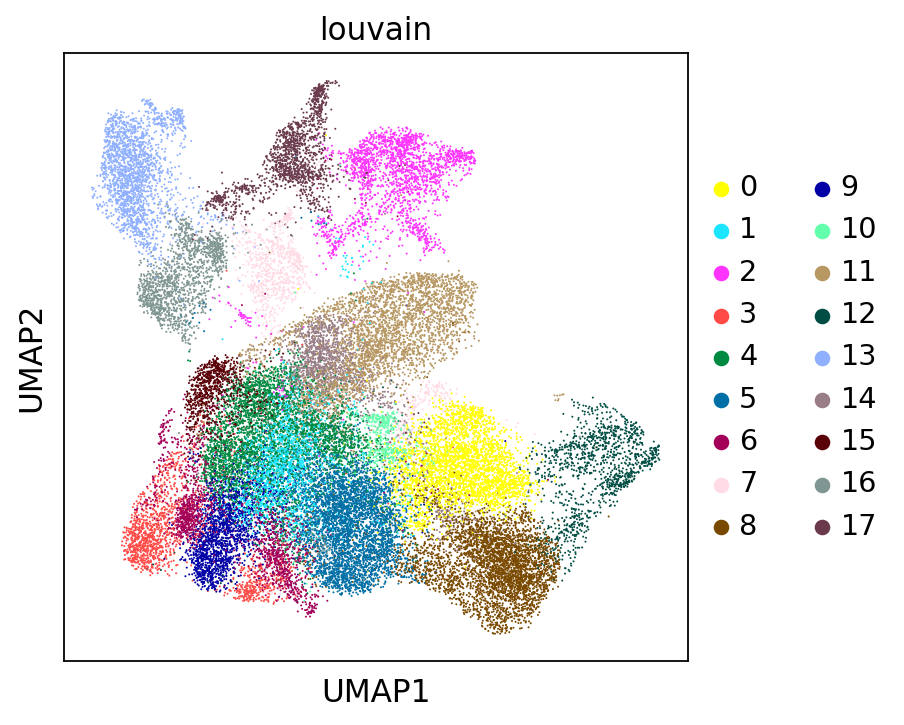

In [45]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [46]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 470 ms, sys: 717 ms, total: 1.19 s
Wall time: 185 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


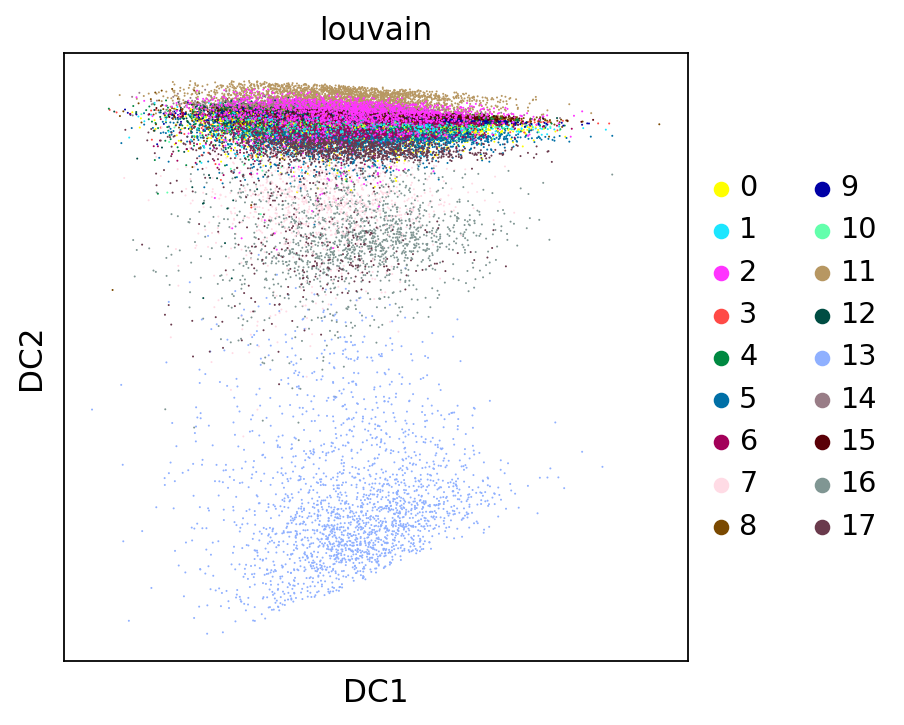

In [47]:
sc.pl.diffmap(tdata, color='louvain')

In [48]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 237 ms, sys: 4.73 ms, total: 242 ms
Wall time: 241 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


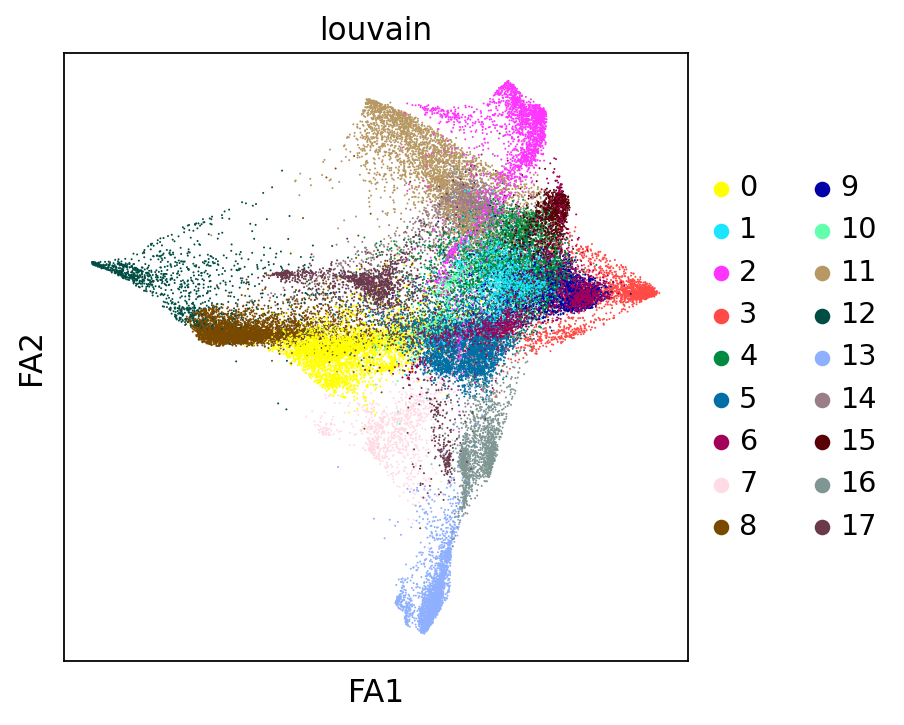

In [49]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [50]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 27.735387802124023


## Decoupler-GPU

Here I introduce 2 functions of the `decoupler` package that have been accelerated with cupy: `mlm`and `wsum`.
You can use the same `nets` that you would use with the CPU implementation.

In [51]:
import decoupler as dc

In [52]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])

In [53]:
%%time
rsc.dcg.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running mlm on mat with 91068 samples and 25656 targets for 297 sources.


100%|███████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


CPU times: user 8.49 s, sys: 4.23 s, total: 12.7 s
Wall time: 12.7 s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


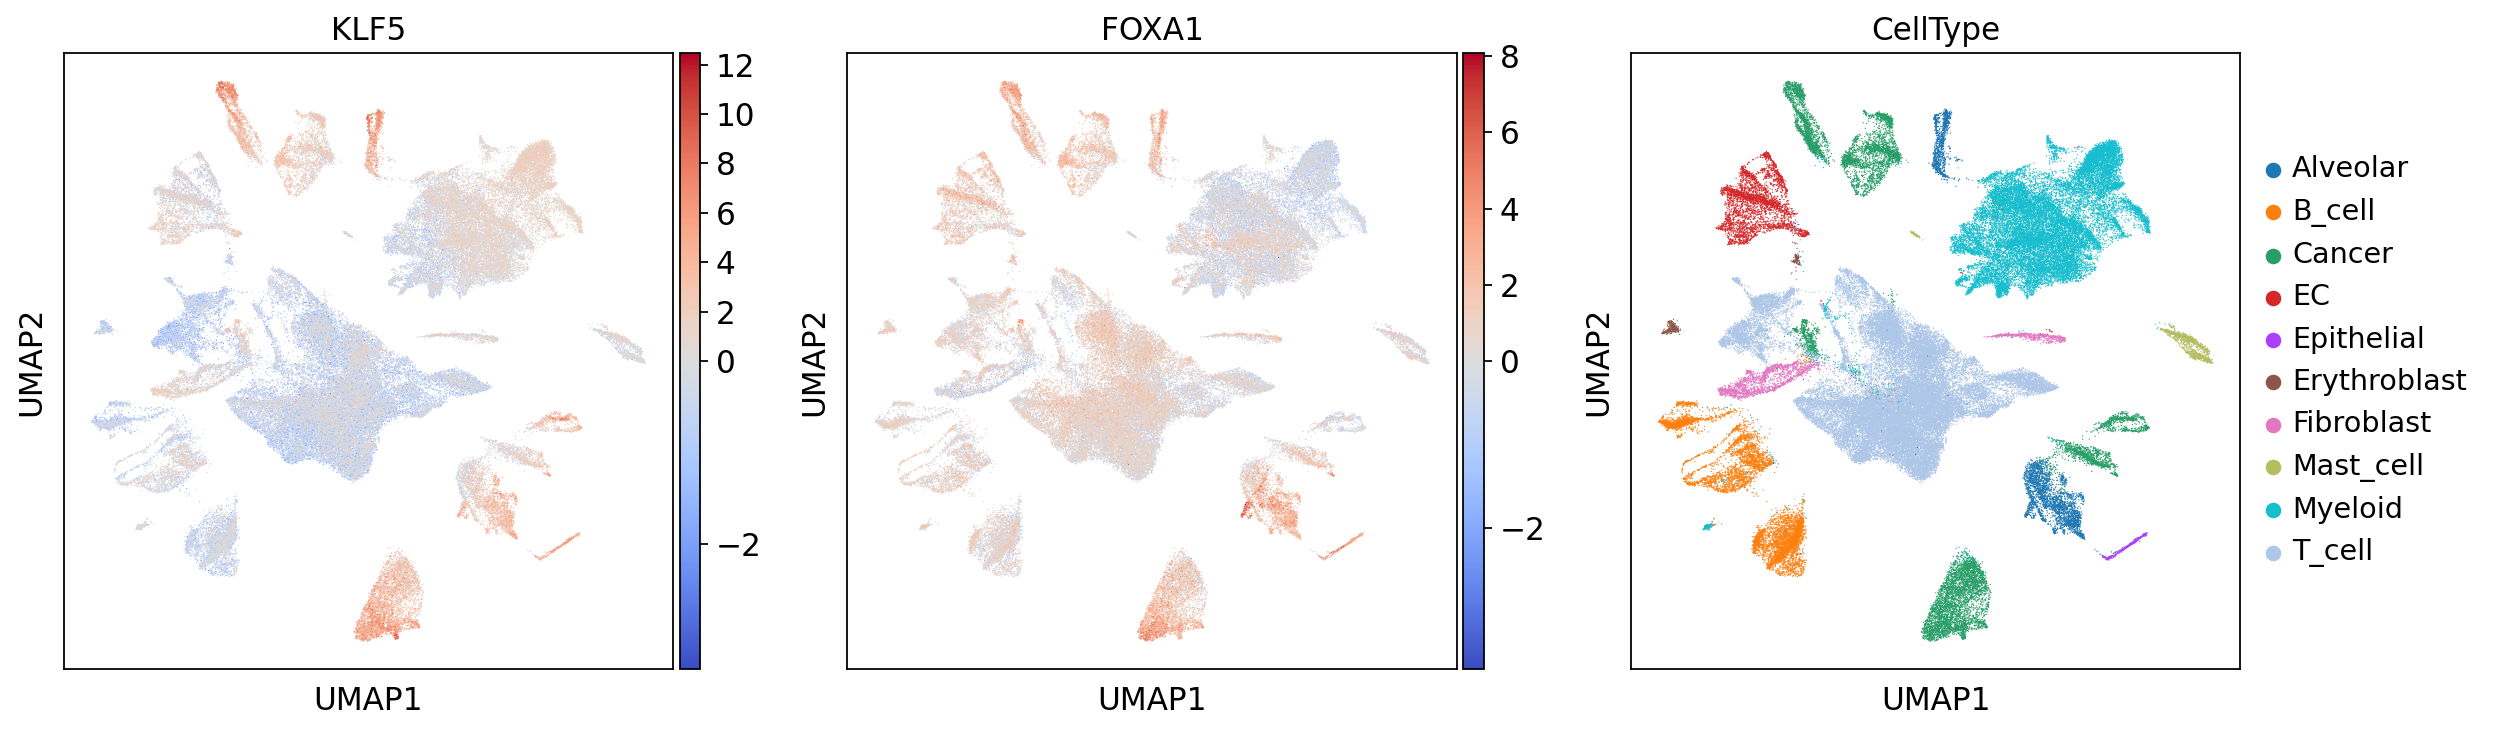

In [54]:
acts_mlm = dc.get_acts(adata, obsm_key='mlm_estimate')
sc.pl.umap(acts_mlm, color=['KLF5',"FOXA1", 'CellType'], cmap='coolwarm', vcenter=0)

In [55]:
model = dc.get_progeny(organism='human', top=100)

In [56]:
%%time
rsc.dcg.run_wsum(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running wsum on mat with 91068 samples and 25656 targets for 14 sources.
Infering activities on 10 batches.


100%|███████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]

CPU times: user 49.5 s, sys: 23 s, total: 1min 12s
Wall time: 26.8 s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


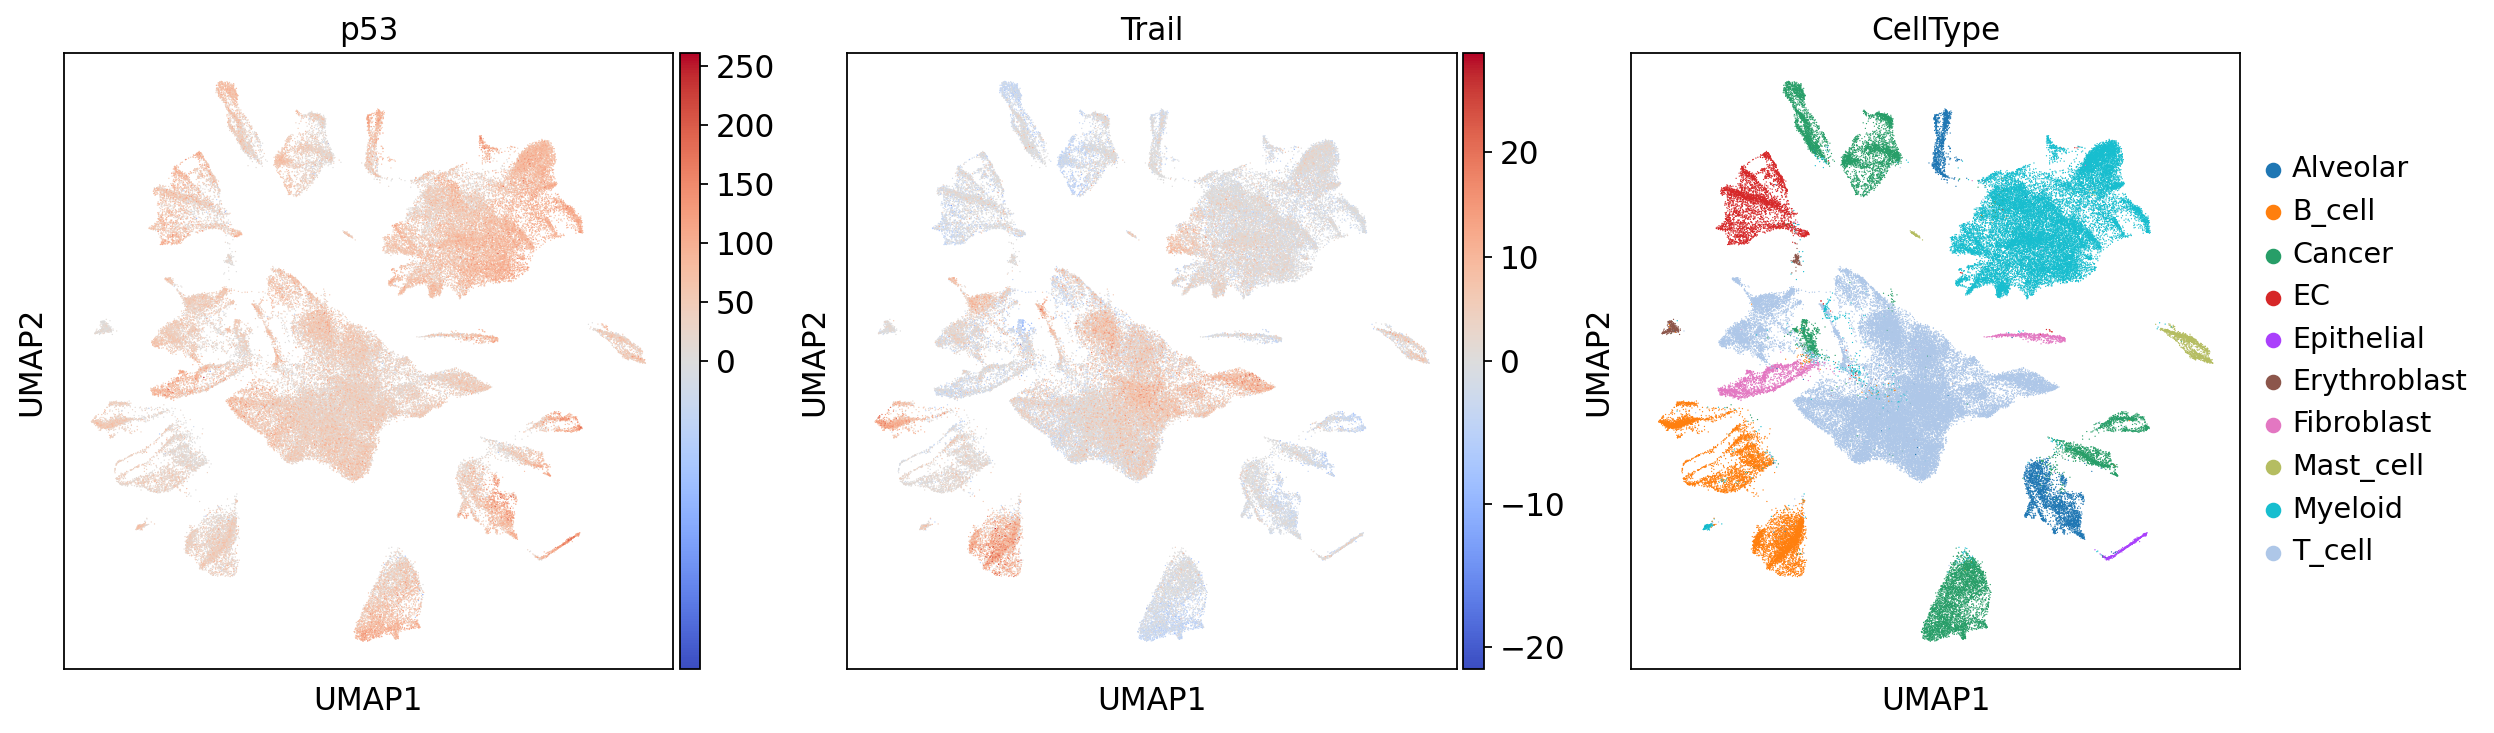

In [57]:
acts_wsum = dc.get_acts(adata, obsm_key='wsum_estimate')
sc.pl.umap(acts_wsum, color=['p53',"Trail", 'CellType'], cmap='coolwarm', vcenter=0)